In [1]:
import os
import pandas as pd
#import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import time
import pdb
import pickle
import random
import datetime 

In [2]:
%matplotlib notebook

# Data loading

In [3]:
data17_tg=pd.read_excel('EMIVASA_validationOutput.xlsx',sheet_name='sH2O users') # 2017 data - treatment group
data17_cg=pd.read_excel('EMIVASA_validationOutput.xlsx',sheet_name='Control group') # 2017 data - control group
data_tg_hour = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Horaria',converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group hourly frequency
data_tg_day = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Diaria', converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group daily frequency
data_tg_visual = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_visual',converters={'ENTORNO': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group visual reading

data19=pd.read_excel("Datos consumo hasta febrero 2019.xls") # 2019 data

In [4]:
# Merging user ID
data_tg_hour.keys()
data_tg_hour['User_ID']='AGM' + (data_tg_hour.NIA.astype(str))
data_tg_hour['User_ID']=data_tg_hour.User_ID.str.cat(data_tg_hour.SUBNIA.astype(str))
data_tg_day['User_ID']='AGM' + (data_tg_day.NIA.astype(str))
data_tg_day['User_ID']=data_tg_day.User_ID.str.cat(data_tg_day.SUBNIA.astype(str))
data_tg_visual['User_ID']='AGM' + (data_tg_visual.NIA.astype(str))
data_tg_visual['User_ID']=data_tg_visual.User_ID.str.cat(data_tg_visual.SUBNIA.astype(str))

# Data processing

In [5]:
# Finding user ID of SmartH2O users

# Treatment/control group ID in 2017 dataset
userID17_tg = data17_tg.User_ID
userID17_cg = data17_cg.User_ID

# Treatment/control group ID in 2019 dataset
userID19 = np.unique(data19['ID'])
userID19_tg = np.isin(userID19, userID17_tg) # treatment group
userID19_cg = np.isin(userID19, userID17_cg) # control group

userID19_tg = userID19[userID19_tg==True]
userID19_cg = userID19[userID19_cg==True]

## Storing all data for treatment group (SmartH2O users)

In [6]:
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August

allData_tg = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_tg:

    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser
    
    #print(data19[currUserCondition])
    #pdb.set_trace()

    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170630
    dateConditionEnd18 = data19['FECHA']<=20180228
    
    dateConditionStart18 = data19['FECHA']>=20180630
    dateConditionEnd19 = data19['FECHA']<=20190228

    # Start and end date for summer peak:
    summerConditionStart17 = data19['FECHA']>=20170731 # July
    summerConditionEnd17 = data19['FECHA']<=20170831 # August

    summerConditionStart18 = data19['FECHA']>=20180731 # July
    summerConditionEnd18 = data19['FECHA']<=20180831 # August
    
    # ::: Evaluating average consumption
    tg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    tg_data1718_sp = data19[currUserCondition & summerConditionStart17 & summerConditionEnd17] # Summer peak 17

    tg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    tg_data1819_sp = data19[currUserCondition & summerConditionStart18 & summerConditionEnd18] # Summer peak 18
    
    # Number of days for each period
    #
    # Observation period 17-18
    startD = datetime.datetime.strptime(str(tg_data1718.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
    nDays1718 = (endD-startD).days + startD.day 
    #
    # Observation period 18-19
    startD = datetime.datetime.strptime(str(tg_data1819.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
    nDays1819 = (endD-startD).days + startD.day
    #
    # Summer peak 17
    startD = datetime.datetime.strptime(str(tg_data1718_sp.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1718_sp.iloc[-1]['FECHA']),'%Y%m%d') 
    nDays1718_sp = (endD-startD).days + startD.day 
    #
    # Summer peak 18
    startD = datetime.datetime.strptime(str(tg_data1819_sp.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1819_sp.iloc[-1]['FECHA']),'%Y%m%d') 
    nDays1819_sp = (endD-startD).days + startD.day
    
    # Average consumption values
    tg_data1718_avg = sum(tg_data1718['CONSUMO'])/nDays1718
    tg_data1819_avg = sum(tg_data1819['CONSUMO'])/nDays1819
    tg_data1718_avg_sp = sum(tg_data1718_sp['CONSUMO'])/nDays1718_sp
    tg_data1819_avg_sp = sum(tg_data1819_sp['CONSUMO'])/nDays1819_sp
    
    freq=[]
    if (np.isin(currUser, np.unique(data_tg_hour['User_ID']))):
        freq = 'hourly readings'
    elif (np.isin(currUser, np.unique(data_tg_day['User_ID']))):
        freq = 'daily readings'
    elif (np.isin(currUser, np.unique(data_tg_visual['User_ID']))):
        freq = 'visual readings'
    else:
        freq = np.nan

    # All data to save
    tempDf = pd.DataFrame({"User_ID":currUser, 
                           "avg_baseline":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_baseline'],
                           "avg_1617":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_observation'],
                           "avg_1718":tg_data1718_avg,
                           "avg_1819":tg_data1819_avg,
                           "avg_sp_17":tg_data1718_avg_sp,
                           "avg_sp_18":tg_data1819_avg_sp,
                           "tg": 1,
                           "freq": freq
                          }) 
    allData_tg=allData_tg.append(tempDf,ignore_index=True)
    allData_tg.to_csv('/Users/aco/tubCloud/_RESEARCH/SmartH2O_evolution/2019_AGU/allData_tg.csv',index=False)
    

## Storing all data for control group

In [7]:
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August

allData_cg = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_cg:
    #print(currUser)
    #print(data19[currUserCondition])
    #pdb.set_trace()
    
    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser
    
    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170630
    dateConditionEnd18 = data19['FECHA']<=20180228
    
    dateConditionStart18 = data19['FECHA']>=20180630
    dateConditionEnd19 = data19['FECHA']<=20190228

    # Start and end date for summer peak:
    summerConditionStart17 = data19['FECHA']>=20170731 # July
    summerConditionEnd17 = data19['FECHA']<=20170831 # August

    summerConditionStart18 = data19['FECHA']>=20180731 # July
    summerConditionEnd18 = data19['FECHA']<=20180831 # August
    
    # ::: Evaluating average consumption
    cg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    cg_data1718_sp = data19[currUserCondition & summerConditionStart17 & summerConditionEnd17] # Summer peak 17

    cg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    cg_data1819_sp = data19[currUserCondition & summerConditionStart18 & summerConditionEnd18] # Summer peak 18
    
    # Number of days for each period
    #
    # Observation period 17-18
    startD = datetime.datetime.strptime(str(cg_data1718.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(cg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
    nDays1718 = (endD-startD).days + startD.day 
    #
    # Observation period 18-19
    startD = datetime.datetime.strptime(str(cg_data1819.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(cg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
    nDays1819 = (endD-startD).days + startD.day
    #
    # Summer peak 17
    if (cg_data1718_sp.empty == False):
        startD = datetime.datetime.strptime(str(cg_data1718_sp.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1718_sp.iloc[-1]['FECHA']),'%Y%m%d') 
        nDays1718_sp = (endD-startD).days + startD.day 
    #
    # Summer peak 18
    if (cg_data1819_sp.empty == False):
        startD = datetime.datetime.strptime(str(cg_data1819_sp.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1819_sp.iloc[-1]['FECHA']),'%Y%m%d') 
        nDays1819_sp = (endD-startD).days + startD.day
    
    # Average consumption values
    cg_data1718_avg = sum(cg_data1718['CONSUMO'])/nDays1718
    cg_data1819_avg = sum(cg_data1819['CONSUMO'])/nDays1819
    if (cg_data1718_sp.empty == False):
        cg_data1718_avg_sp = sum(cg_data1718_sp['CONSUMO'])/nDays1718_sp
    else: 
        cg_data1718_avg_sp = np.nan
    if (cg_data1819_sp.empty == False): 
        cg_data1819_avg_sp = sum(cg_data1819_sp['CONSUMO'])/nDays1819_sp
    else: 
        cg_data1819_avg_sp = np.nan

    # All data to save
    tempDf = pd.DataFrame({"User_ID":currUser, 
                           "avg_baseline":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_baseline'],
                           "avg_1617":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_observation'],
                           "avg_1718":cg_data1718_avg,
                           "avg_1819":cg_data1819_avg,
                           "avg_sp_17":cg_data1718_avg_sp,
                           "avg_sp_18":cg_data1819_avg_sp,
                           "tg": 0
                          }) 
    allData_cg=allData_cg.append(tempDf,ignore_index=True)
    

## Overall water consumption change

In [8]:
# Deleting outliers
allData_cgTemp = allData_cg[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819','avg_sp_17', 'avg_sp_18']]
allData_cgTemp['avg_baseline'] = allData_cgTemp.avg_baseline.astype(float)
allData_cgTemp['avg_1617'] = allData_cgTemp.avg_1617.astype(float)
allData_cgTemp['avg_1718'] = allData_cgTemp.avg_1718.astype(float)
allData_cgTemp['avg_1819'] = allData_cgTemp.avg_1819.astype(float)
allData_cgTemp['avg_sp_17'] = allData_cgTemp.avg_sp_17.astype(float)
allData_cgTemp['avg_sp_18'] = allData_cgTemp.avg_sp_18.astype(float)
toKeep1 = (allData_cgTemp >= 0).all(1)
toKeep2 = (allData_cgTemp < 1).all(1)

allData_cg = allData_cg[toKeep1 & toKeep2]


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [9]:
#::: SmartH2O treatment group
# % change wrt baseline
avg_percC_tg=[]
avg_percC_tg.append(np.median(np.divide((allData_tg['avg_1617'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
avg_percC_tg.append(np.median(np.divide((allData_tg['avg_1718'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
avg_percC_tg.append(np.median(np.divide((allData_tg['avg_1819'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
print(avg_percC_tg)
# Tot vol change wrt baseline
avg_volC_tg = []
avg_volC_tg.append(((np.sum(allData_tg['avg_1617']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
avg_volC_tg.append(((np.sum(allData_tg['avg_1718']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
avg_volC_tg.append(((np.sum(allData_tg['avg_1819']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
print(avg_volC_tg)
# Per-capita vol change wrt baseline
avg_volC_pc_tg = []
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1617']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1617'])*100)
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1718']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1718'])*100)
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1819']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1819'])*100)
print(avg_volC_pc_tg)

#::: SmartH2O control group
# % change wrt baseline
avg_percC_cg=[]
avg_percC_cg.append(np.median(np.divide((allData_cg['avg_1617'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
avg_percC_cg.append(np.median(np.divide((allData_cg['avg_1718'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
avg_percC_cg.append(np.median(np.divide((allData_cg['avg_1819'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
print(avg_percC_cg)
# Vol change wrt baseline
avg_volC_cg = []
avg_volC_cg.append((np.sum(allData_cg['avg_1617']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
avg_volC_cg.append((np.sum(allData_cg['avg_1718']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
avg_volC_cg.append((np.sum(allData_cg['avg_1819']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
print(avg_volC_cg)
# Per-capita vol change wrt baseline
avg_volC_pc_cg = []
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1617']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1617'])*100)
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1718']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1718'])*100)
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1819']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1819'])*100)
print(avg_volC_pc_cg)


[-4.117631798472697, -9.117013228893569, -8.644787900408996]
[-5.6695408539554695, -10.894236827851817, -7.840679225176948]
[-1.4982104079630185, -2.8788678700347203, -2.0719468336600833]
[15.588218207878754, 23.58100059317867, 21.287080497141233]
[15.611940931357578, 13.418606045612222, 18.420270849717646]
[2.9305233338840133, 2.5188116133516663, 3.457676004470188]


## Summer peak water consumption change 

In [10]:
#::: SmartH2O treatment group VS control group
# Vol change 
avg_volC_sp_tg = []
avg_volC_sp_tg.append(np.median(allData_tg['avg_sp_17']))
avg_volC_sp_tg.append(np.median(allData_tg['avg_sp_18']))
avg_volC_sp_cg = []
avg_volC_sp_cg.append(np.median(allData_cg['avg_sp_17']))
avg_volC_sp_cg.append(np.median(allData_cg['avg_sp_18']))
                      
print(avg_volC_sp_tg)
print(avg_volC_sp_cg)


[0.16336290322580643, 0.15832258064516128]
[0.1504548387096774, 0.1500668202764977]


## Results visualization

<IPython.core.display.Javascript object>


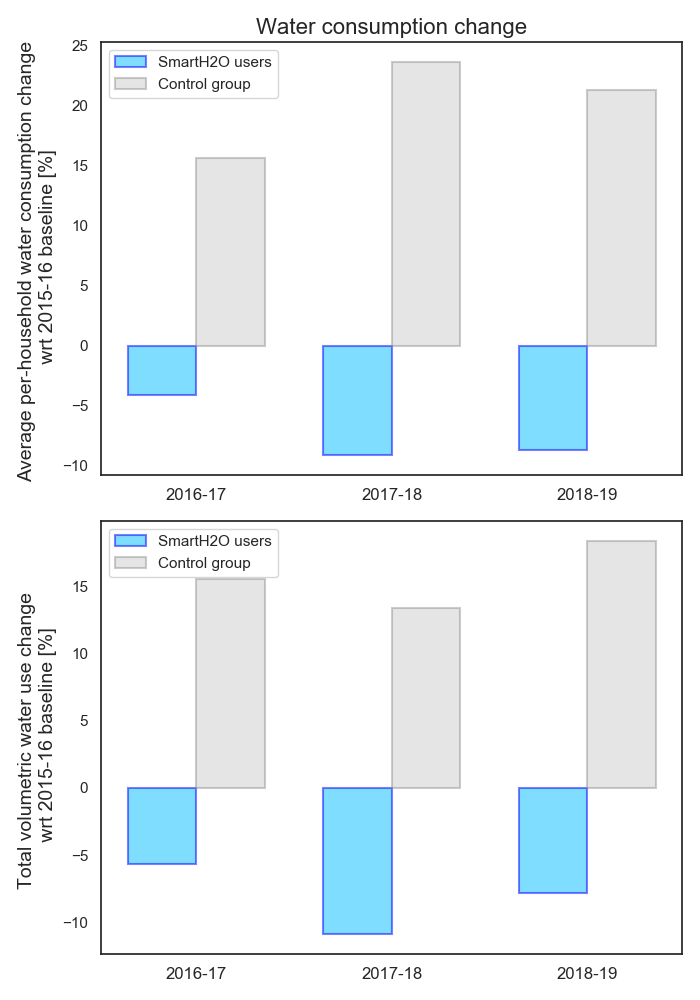

In [26]:
# ::: Water use change 
labels = ['2016-17','2017-18','2018-19']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams['figure.figsize'] = [7, 10]
fig, ax = plt.subplots(2)

# Percentage water use change
rects1 = ax[0].bar(x - width/2, avg_percC_tg, width, label='SmartH2O users',color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[0].bar(x + width/2, avg_percC_cg, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('Average per-household water consumption change \n wrt 2015-16 baseline [%]',fontsize=14)
ax[0].set_title('Water consumption change', fontsize=16)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, fontsize=12)
ax[0].legend()
fig.tight_layout()
plt.show()

# Volumetric water use change
rects1 = ax[1].bar(x - width/2, avg_volC_tg, width, label='SmartH2O users', color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[1].bar(x + width/2, avg_volC_cg, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_ylabel('Total volumetric water use change \n wrt 2015-16 baseline [%]',  fontsize=14)
#ax[1].set_title('Percentage water use change ')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, fontsize=12)
ax[1].legend()
fig.tight_layout()
plt.show()
fig.savefig("sH2O_tgVScg.pdf", bbox_inches='tight')





<IPython.core.display.Javascript object>


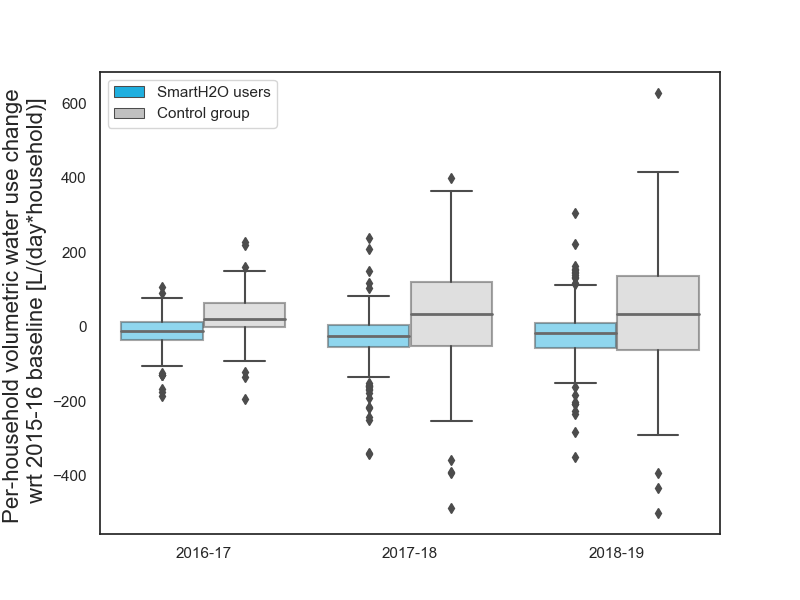

In [18]:
# Boxplot with consumption
tempDf_tg = pd.DataFrame({"2016-17":((allData_tg['avg_1617'] - allData_tg['avg_baseline'])*1000),
                       "2017-18":((allData_tg['avg_1718'] - allData_tg['avg_baseline'])*1000),
                       "2018-19":((allData_tg['avg_1819'] - allData_tg['avg_baseline'])*1000)#,
                       #"tg": allData_tg['tg'] 
                      }) 
tempDf_cg = pd.DataFrame({"2016-17":((allData_cg['avg_1617'] - allData_cg['avg_baseline'])*1000),
                       "2017-18":((allData_cg['avg_1718'] - allData_cg['avg_baseline'])*1000),
                       "2018-19":((allData_cg['avg_1819'] - allData_cg['avg_baseline'])*1000)#,
                       #"tg": allData_cg['tg'] 
                      })
tempDf_tg = pd.melt(tempDf_tg)
tempDf_tg.insert(1, 'tg', 'SmartH2O users')
tempDf_cg = pd.melt(tempDf_cg)
tempDf_cg.insert(1, 'tg', 'Control group')
tempDf = tempDf_tg
tempDf=tempDf.append(tempDf_cg)

import seaborn as sns 
plt.rcParams['figure.figsize'] = [8, 6]
fig=plt.figure()# Grouped boxplot
ax = fig.gca()
sns.set(style='white')
boxprops = dict(linestyle='-', linewidth=1.5, alpha = 0.5)
medianprops = dict(linestyle='-', linewidth=2, color='dimgray')
sns.boxplot(x="variable", y="value", hue ="tg", data=tempDf, palette=('deepskyblue', 'silver'), linewidth = 1.5, boxprops=boxprops, medianprops=medianprops)
ax.set_xlabel('')
ax.set_ylabel('Per-household volumetric water use change \n wrt 2015-16 baseline [L/(day*household)]', fontsize=16)
plt.legend()
fig.savefig("sH2O_tgVScg_vol.pdf", bbox_inches='tight')

<IPython.core.display.Javascript object>


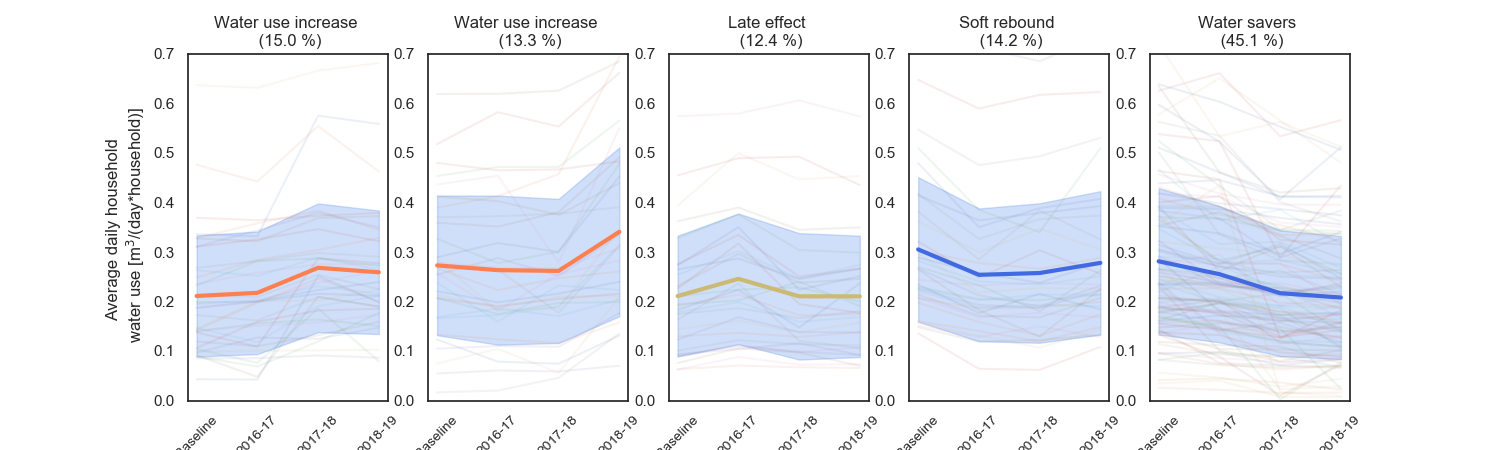

In [19]:
# Clustering patterns
import scipy.cluster.hierarchy as spc
import matplotlib.colors as mcolors

df = allData_tg[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819']]
df = df.transpose()
corr = df.corr()

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.7 * pdist.max(), 'distance')

# Representing clustered patterns
plt.rcParams['figure.figsize'] = [15, 4.5]
fig, ax = plt.subplots(1,np.max(idx))
for i in range(np.max(idx)):
    toPlot = df.iloc[:,idx==i+1]
    ax[i].plot(toPlot,alpha=0.1)
    toPlotMean = np.mean(toPlot, axis=1)
    line = ax[i].lines[0] # get the first line, there might be more
    x=line.get_xdata()
    col = ['coral', 'coral', 'y', 'royalblue', 'royalblue']
    ax[i].fill_between(x,toPlotMean-np.std(toPlot, axis=1), toPlotMean+np.std(toPlot, axis=1), color ='cornflowerblue', alpha = 0.3)
    ax[i].plot(toPlotMean, linewidth=3, c=col[i] )
    ax[i].set_ylim([0, 0.7])

ax[0].set_title('Water use increase \n (%.1f %%)' % (sum(idx==1)/len(idx)*100), fontsize=12)
ax[1].set_title('Water use increase \n (%.1f %%)' % (sum(idx==2)/len(idx)*100), fontsize=12)
ax[2].set_title('Late effect \n (%.1f %%)' % (sum(idx==3)/len(idx)*100), fontsize=12)
ax[3].set_title('Soft rebound \n (%.1f %%)' % (sum(idx==4)/len(idx)*100), fontsize=12)
ax[4].set_title('Water savers \n (%.1f %%)' % (sum(idx==5)/len(idx)*100), fontsize=12)
ax[0].set_ylabel('Average daily household \n water use [m$^3$/(day*household)]', fontsize = 12)
ax[0].set_xticklabels(['Baseline','2016-17','2017-18','2018-19'], fontsize=10, rotation=45)
ax[1].set_xticklabels(['Baseline','2016-17','2017-18','2018-19'], fontsize=10, rotation=45)
ax[2].set_xticklabels(['Baseline','2016-17','2017-18','2018-19'], fontsize=10, rotation=45)
ax[3].set_xticklabels(['Baseline','2016-17','2017-18','2018-19'], fontsize=10, rotation=45)
ax[4].set_xticklabels(['Baseline','2016-17','2017-18','2018-19'], fontsize=10, rotation=45)

fig.savefig("sH2O_tg_clusters.pdf", bbox_inches='tight')


<IPython.core.display.Javascript object>


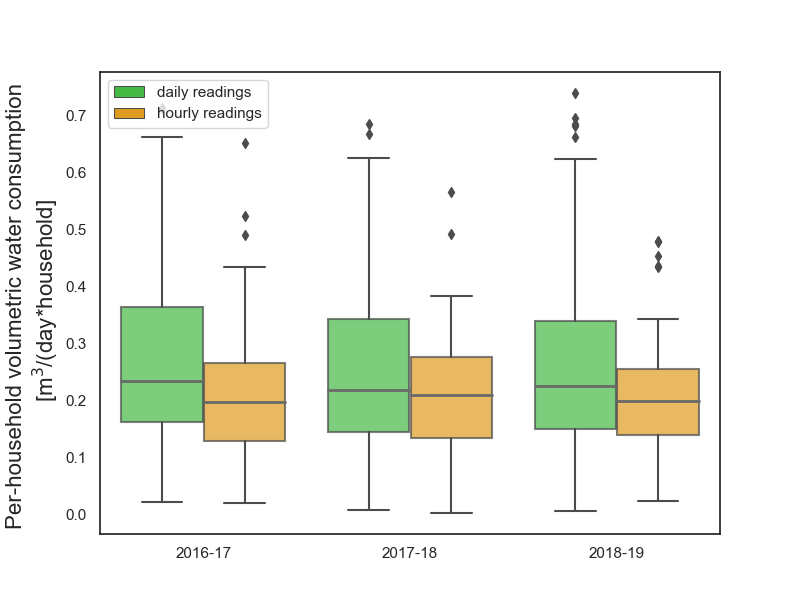

In [24]:
# Correlation with metering frequency
df = allData_tg[['avg_1617', 'avg_1718', 'avg_1819', 'freq']]
toPlot = pd.DataFrame({"2016-17":df['avg_1617'],
                       "2017-18":df['avg_1718'],
                       "2018-19":df['avg_1819'],
                       "freq": df['freq']
                      }) 
df=toPlot
df = df[~pd.isna(df['freq'])]
dfTemp = df

df=df.drop('freq',1)
df = pd.melt(df)
dfTemp=pd.concat([dfTemp['freq'],dfTemp['freq'], dfTemp['freq']])
dfTemp.index = df.index
tempFreq = pd.DataFrame({"freq":dfTemp})
df.insert(1, 'freq', tempFreq['freq'])

plt.rcParams['figure.figsize'] = [8, 6]
fig=plt.figure()# Grouped boxplot
ax = fig.gca()
sns.set(style='white')
boxprops = dict(linestyle='-', linewidth=1.5, alpha = 0.7)
medianprops = dict(linestyle='-', linewidth=2, color='dimgray')
sns.boxplot(x="variable", y="value", hue ="freq", data=df, palette=('limegreen', 'orange'), linewidth = 1.5, boxprops=boxprops, medianprops=medianprops)
ax.set_xlabel('')
ax.set_ylabel('Per-household volumetric water consumption \n [m$^3$/(day*household]', fontsize=16)
plt.legend()
fig.savefig("sH2O_tg_freq.pdf", bbox_inches='tight')


In [27]:
allData_cg


,User_ID,avg_baseline,avg_1617,avg_1718,avg_1819,avg_sp_17,avg_sp_18,tg
0,AGM00147142003,0.162246,0.070598,0.061597,0.059214,0.218790,0.221887,0
1,AGM00147142004,0.095134,0.152075,0.137877,0.155510,0.170306,0.154790,0
2,AGM01078065001,0.355406,0.426010,0.446485,0.442519,0.456342,0.483724,0
3,AGM01106590002,0.033375,0.055880,0.035714,0.005128,0.357143,0.000000,0
4,AGM01115472002,0.133241,0.260708,0.264526,0.250388,0.292381,0.316703,0
...,...,...,...,...,...,...,...,...
123,AGM02248704001,0.085166,0.078151,0.448460,0.358766,0.660979,0.370711,0
124,AGM02252058001,0.230843,0.226873,0.000000,0.000000,0.000000,0.000000,0
125,AGM02290506001,0.058935,0.029882,0.188767,0.202624,0.179429,0.187004,0
126,AGM02290538001,0.153136,0.191705,0.042430,0.050843,0.140442,0.127198,0


In [28]:
allData_tg

,User_ID,avg_baseline,avg_1617,avg_1718,avg_1819,avg_sp_17,avg_sp_18,tg,freq
0,AGM01006538001,0.414406,0.363943,0.378612,0.392897,0.392218,0.611865,1,daily readings
1,AGM01006571003,0.638816,0.603542,0.553047,0.506599,0.602687,0.501235,1,daily readings
2,AGM01013095003,0.244562,0.229682,0.228142,0.213938,0.009756,0.019616,1,daily readings
3,AGM01024475002,0.264752,0.286715,0.245490,0.266304,0.190871,0.207306,1,hourly readings
4,AGM01031367001,0.207316,0.200214,0.216720,0.139957,0.316565,0.109048,1,hourly readings
...,...,...,...,...,...,...,...,...,...
221,AGM02338258001,0.232448,0.281685,0.287045,0.272086,0.251837,0.220331,1,daily readings
222,AGM02339637002,0.074767,0.104165,0.056004,0.208708,0.020871,0.053468,1,hourly readings
223,AGM02345170001,0.166251,0.172668,0.190292,0.314242,0.187548,0.312355,1,daily readings
224,AGM02345576001,0.212077,0.197657,0.180220,0.159372,0.135371,0.134731,1,daily readings
